In [8]:
from glob import glob
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, io
from skimage.color import label2rgb
from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import expand_labels, watershed
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import segmentation
from skimage import data, restoration, util
from skimage import data, morphology
from skimage.filters import threshold_otsu, threshold_yen
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, area_closing
from skimage.color import label2rgb
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
plt.rcParams['figure.figsize'] = [10, 5]

In [11]:
DATASET_ROOT = r"/home/shared/datasets/pollen_dataset_2024_08_14/"
# OBJECTS_ROOT_1 = r"/home/shared/datasets/pollen_dataset_2024_05_08_objects"
OBJECTS_ROOT_1 = r"/home/jovyan/pollen_dataset_2024_05_08_objects"

In [36]:
all_classes = os.listdir(DATASET_ROOT)
print(f"Total amount of classes: {len(all_classes)}")
print(all_classes)

Total amount of classes: 18
['Alnus', 'Betula', 'Corylus', 'Acer', 'Chenopodiaceae', 'Pinus', 'Poaceae', 'Apiaceae', 'Rumex', 'Salix', 'Populus tremula', 'Urtica', 'Artemisia', 'Picea', 'Tilia', 'Plantago', 'Quercus', 'Fraxinus']


In [ ]:
# config_radius = {}
# config_radius['Picea'] = 50
# config_radius['Apiaceae'] = 25
# config_square = {}
# config_square['Picea'] = 25
# config_square['Apiaceae'] = 10
# config_area_threshold = {}
# config_area_threshold['Picea'] = 50000
# config_area_threshold['Apiaceae'] = 1000

In [173]:
target_classes = ['Apiaceae']

In [174]:
all_images = []
for class_name in target_classes:
    all_images.extend(glob(os.path.join(DATASET_ROOT, class_name, "*.jpg"), recursive=True))
print(f"Total amount of images: {len(all_images)}")

Total amount of images: 71


# Visualisation 

In [175]:
def draw_detections(image, label_image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
    
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    ax1.imshow(image)
    ax2.imshow(image_label_overlay)
    # for region in regionprops(label_image):
    #     # draw rectangle around segmented coins
    #     minr, minc, maxr, maxc = region.bbox
    #     rect = mpatches.Rectangle(
    #         (minc, minr),
    #         maxc - minc,
    #         maxr - minr,
    #         fill=False,
    #         edgecolor='red',
    #         linewidth=2,
    #     )
    #     ax.add_patch(rect)
    
    ax1.set_axis_off()
    ax2.set_axis_off()
    plt.tight_layout()
    plt.show()

# Detect objects

In [222]:
def object_detection_stage(image_rgb, radius=25):
    image_rgb = np.copy(image_rgb)
    image = rgb2gray(image_rgb)
    # apply threshold
    thresh = threshold_yen(image)
    bw = closing(image < thresh, square(25))
    bw =  morphology.remove_small_holes(
        morphology.remove_small_objects(bw, 5000), 5000
    )
    bw = morphology.isotropic_erosion(bw, radius)
    bw = morphology.isotropic_dilation(bw, radius)
    
    # # remove artifacts connected to image border
    # cleared = clear_border(bw)
    # label image regions
    label_image = label(bw)
    return label_image

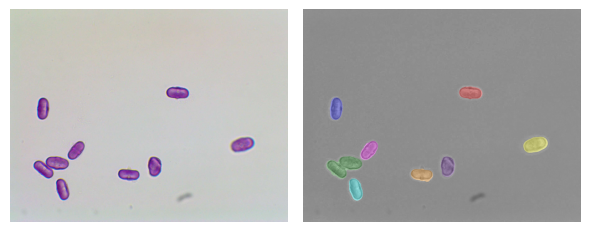

In [225]:
image_rgb = io.imread(all_images[10])
label_image = object_detection_stage(image_rgb)
draw_detections(image_rgb, label_image)

# Extract detected objects

# Separate Objects

In [200]:
def extract_objects(image_rgb, labels_image, min_distance, padding):
    labels = ndi.binary_fill_holes(labels_image)
    labels = morphology.binary_erosion(labels)
    labels = morphology.binary_dilation(labels).astype(np.uint8)
    
    # # Now we want to separate the two objects in image
    # # Generate the markers as local maxima of the distance to the background
    distance = ndi.distance_transform_edt(labels)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=labels, min_distance=min_distance)
    if len(coords) > 0:
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        # draw_detections(distance, distance)
        markers, _ = ndi.label(mask)
        labels = watershed(-distance, markers, mask=labels)


    masked_rgb_images = []
    for region in regionprops(labels):
        # print(image_rgb_patch.shape)
        # print(region.bbox)
        minr, minc, maxr, maxc = region.bbox    
        # print(minr, minc, maxr, maxc)
        minr, minc, maxr, maxc = max(0, minr-padding), max(0, minc-padding), min(image_rgb.shape[0]-1, maxr+padding), min(image_rgb.shape[1]-1, maxc+padding)
        # print(minr, minc, maxr, maxc)
        label_patch = np.copy(labels[minr:maxr, minc:maxc])
        label_patch = clear_border(label_patch)
        image_rgb_patch = np.copy(image_rgb[minr:maxr, minc:maxc])
        image_rgb_patch = np.where((label_patch > 0)[...,None], image_rgb_patch, 0).astype(np.uint8)
        masked_rgb_images.append(image_rgb_patch)
        # draw_detections(image_rgb_patch, label_patch)
    # candidates = []
    return masked_rgb_images
    

def object_separation_stage(image_rgb, labels, area_threshold=1000, padding=10, min_distance=250):
    image_rgb = np.copy(image_rgb)
    masked_rgb_images = []
    for region in regionprops(labels):
        if region.area < area_threshold:
            continue  # Пропуск мелких объектов
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox            
        minr, minc, maxr, maxc = max(0, minr-padding), max(0, minc-padding), min(image_rgb.shape[0]-1, maxr+padding), min(image_rgb.shape[1]-1, maxc+padding)
        
        label_patch = np.copy(labels[minr:maxr, minc:maxc])
        label_patch = clear_border(label_patch)
        image_rgb_patch = np.copy(image_rgb[minr:maxr, minc:maxc])
        image_rgb_patch = np.where((label_patch > 0)[...,None], image_rgb_patch, 0).astype(np.uint8)
        masked_rgb_images.extend(extract_objects(image_rgb_patch, label_patch, min_distance, padding))
    return masked_rgb_images

In [205]:
image_rgb = io.imread(all_images[10])
label_image = object_detection_stage(image_rgb)
masked_rgb_images = object_separation_stage(image_rgb, label_image)
print(len(masked_rgb_images))

8


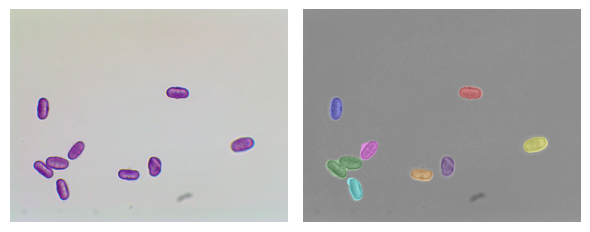

In [206]:
draw_detections(image_rgb, label_image)

In [203]:
for imx, path in enumerate(tqdm(all_images)):
    rel_path = os.path.relpath(path, start=DATASET_ROOT)
    patch_template = os.path.splitext(rel_path)[0] + "_{}.png"
    patch_template = os.path.join(OBJECTS_ROOT_1, patch_template)
    os.makedirs(os.path.dirname(patch_template), exist_ok=True)   
    try:
        image_rgb = io.imread(path)
        label_image = object_detection_stage(image_rgb)
        masked_rgb_images = object_separation_stage(image_rgb, label_image)
        for i, patch in enumerate(masked_rgb_images):
            io.imsave(patch_template.format(i), patch)
    except:
        print(f"Cannot process image {path}")

  0%|          | 0/71 [00:00<?, ?it/s]

In [171]:
# for idx, image_path in enumerate(tqdm(all_images)):
#     if idx % 50 == 0:
#         image_rgb = io.imread(image_path)
#         label_image = object_detection_stage(image_rgb)
#         object_separation_stage(image_rgb, label_image)

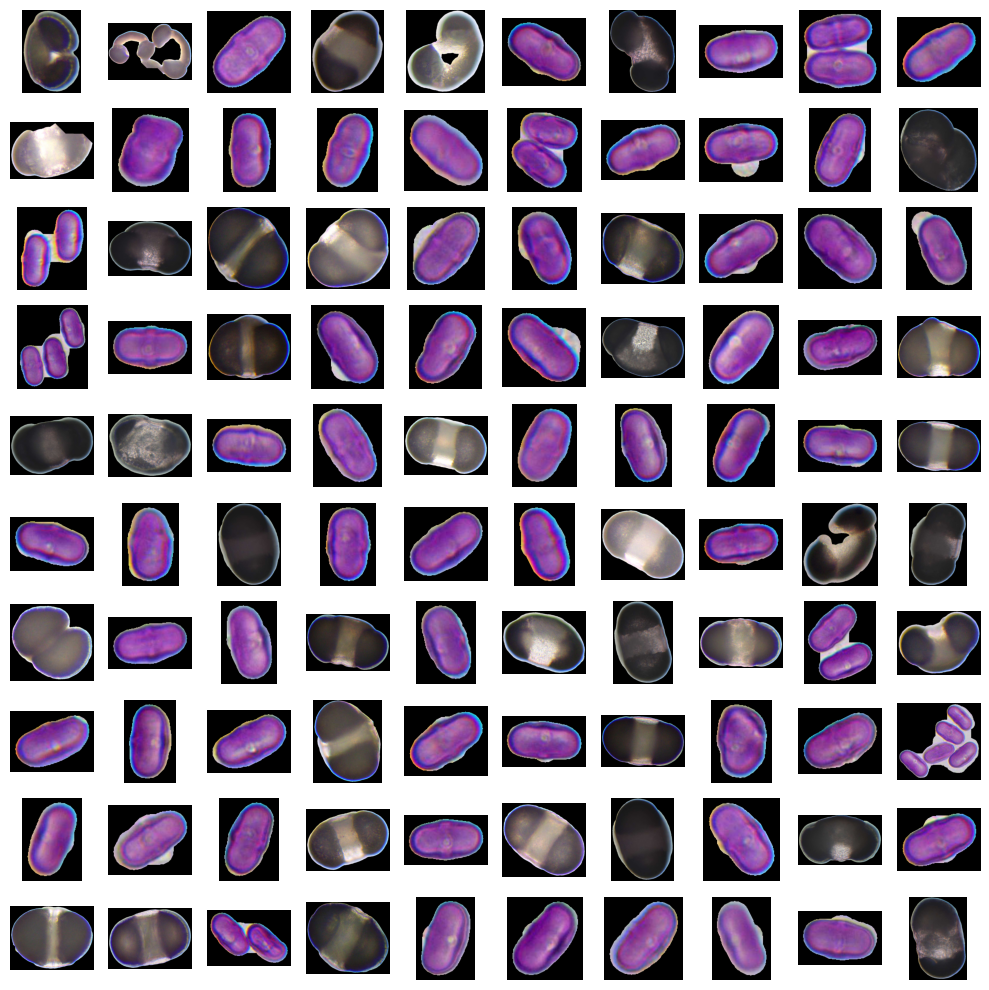

In [204]:
import random

all_obj_images = glob(os.path.join(OBJECTS_ROOT_1,  "**", "*.png"), recursive=True)
all_obj_images = random.sample(all_obj_images, 100)
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for ax, img_path in zip(axs.flatten(), all_obj_images):
    image_rgb = io.imread(img_path)
    ax.imshow(image_rgb)
    ax.set_axis_off()
plt.tight_layout()
plt.savefig("obj_sample.png")
plt.show()